### Load Data

In [2]:
import nltk
from spacy import lemmatizer

def remove_new_line(text):
    text = text.replace('\n', '')
    text = ' '.join(text.split())
    return text

# def lemmatize(review):
#     review = re.sub(r'[^a-zA-Z\s]', '', review)
#     review = review.lower()
#     review = nltk.word_tokenize(review)
#     for y in review :
#         if y not in stpwrds:
#             corpus.append(lemmatizer.lemmatize(y))
#     review = ' '.join(corpus)

In [3]:
import pandas as pd
import numpy as np

df_attributes = pd.read_csv('dataset/stories_attributes.csv')
df_text = pd.read_csv('dataset/stories_in_text.csv')
df_translated = pd.read_csv('dataset/stories_translated.csv')

df = pd.merge(df_attributes, df_text, on=['filename', 'Language'])
df = pd.merge(df, df_translated, on=['filename', 'Language'])
# 0 = truth, 1 = deceptive
df['label'] = np.where(df['Story_type'] == 'Deceptive Story', 1, 0)
df['idx'] = range(len(df))
df['text_line'] = df['text'].apply(remove_new_line)
df = df.drop(columns=['Story_type'])
df

,filename,Language,text,text_english,label,idx,text_line
0,00001.wav,Chinese,2021年的冬天，\n我回了一趟老家探望外婆，\n那年他身体不好，\n住在离村子不远的小镇医...,"In the winter of 2021, I went back to my homet...",0,0,2021年的冬天，我回了一趟老家探望外婆，那年他身体不好，住在离村子不远的小镇医院里，冬天的...
1,00002.wav,Chinese,2022年暑假我终于实现了去云南旅行的梦想。\n云南的美景和独特文化一直是我向往的，\n而这...,I finally realized my dream of traveling to Yu...,0,1,2022年暑假我终于实现了去云南旅行的梦想。云南的美景和独特文化一直是我向往的，而这次旅行让...
2,00003.wav,Chinese,这是我的故事。\n我的旅程从据著名的故宫开始，它是世界上最大保存\n保存最完整的皇宫建筑群。...,This is my story. My journey begins with the f...,0,2,这是我的故事。我的旅程从据著名的故宫开始，它是世界上最大保存保存最完整的皇宫建筑群。当我踏入...
3,00004.wav,Chinese,在2020年呢我报名参加了学校组织的美国研学活动，\n我跟我的另外两个同学以及许多老师同学们...,"In 2020, I registered for the school's organiz...",0,3,在2020年呢我报名参加了学校组织的美国研学活动，我跟我的另外两个同学以及许多老师同学们一起...
4,00005.wav,Chinese,今天我想和大家分享我去年的陕西之旅，\n当我踏上这片古老的土地，心中充满了期待与敬畏。\n我...,"Today, I would like to share with you my trip ...",0,4,今天我想和大家分享我去年的陕西之旅，当我踏上这片古老的土地，心中充满了期待与敬畏。我在陕西之...
...,...,...,...,...,...,...,...
95,00096.wav,English,Uh. \nW is a\n uh my friends and I decided to...,Uh. W is a uh my friends and I decided to go h...,0,95,Uh. W is a uh my friends and I decided to go h...
96,00097.wav,Chinese,上周\n我前往宜家\n孤儿院\n去看望我大学时期志愿服务时认识的小男孩，\n浩浩，\n那是一...,"Last week, I went to IKEA Orphanage to visit t...",1,96,上周我前往宜家孤儿院去看望我大学时期志愿服务时认识的小男孩，浩浩，那是一个安静的冬日午后阳光...
97,00098.wav,Chinese,呃上个周末我和我的朋友们准备去参加一场徒步旅行，\n然后目标是一片森林，\n那天的天气比较阴...,"Last weekend, my friends and I were planning t...",0,97,呃上个周末我和我的朋友们准备去参加一场徒步旅行，然后目标是一片森林，那天的天气比较阴沉，并且...
98,00099.wav,Chinese,啊一次有一次吧我和我的几个朋友去参加一个周末的艺术展览，\n我们都挺喜欢艺术的，所以就提前计...,"Ah, once in a while, my friends and I went to ...",1,98,啊一次有一次吧我和我的几个朋友去参加一个周末的艺术展览，我们都挺喜欢艺术的，所以就提前计划好...


### Features from Text

In [4]:
import codecs
import re

def count_modal_particles(text):
    particles = [
        '啊', '呀', '啦', '吧', '呢', '嘛', '呗', '么', '噢', '呃', '额', '唔', '嗯',
        ' uh ', 'uh,', '\nuh ', 'uh.', ' oh ', 'oh,', '\noh ', 'oh.', ' um ', 'um,', '\num ', 'um.', ' ah ', 'ah,', '\nah ', 'ah.',
    ]
    count = 0
    for particle in particles:
        count += len(re.findall(particle, text.lower()))
    return count

def count_new_line(text):
    return len(re.findall('\n', text))

def calculate_repetition(text):
    words = [w for w in text.split() if w]
    if not words:
        return 0
        
    word_counts = {}
    for word in words:
        word_counts[word] = word_counts.get(word, 0) + 1
    repeated_words = sum(count - 1 for count in word_counts.values())
    repetition_ratio = repeated_words / len(words)
    
    return repetition_ratio

cn_stopwords = set([ line.rstrip() for line in codecs.open('dataset/cn_stop_words.txt',"r", encoding="utf-8")])
en_stopwords = set([ line.rstrip() for line in codecs.open('dataset/en_stop_words.txt',"r", encoding="utf-8")])

def count_stop_words(lang, text):
    stopwords = cn_stopwords if lang == 'Chinese' else en_stopwords
    count = 0
    for word in stopwords:
        pattern = r'\b' + re.escape(word) + r'\b'
        try:
            matches = re.findall(pattern, text.lower())
            count += len(matches)
        except re.error:
            continue
    return count

In [5]:
feats = {
    'is_cn': df['Language'] == 'Chinese', 
    'length_en': df['text_english'].apply(len),
    'modal_particles': df['text'].apply(count_modal_particles),
    'new_line': df['text'].apply(count_new_line),
    'repetition': df['text_line'].apply(calculate_repetition),
    'stop_words': [count_stop_words(row['Language'], row['text_line']) 
                  for _, row in df.iterrows()],
}

df_feats = pd.DataFrame(feats)
df_feats

,is_cn,length_en,modal_particles,new_line,repetition,stop_words
0,True,1730,2,44,0.000000,39
1,True,1898,0,29,0.000000,36
2,True,2158,0,33,0.000000,38
3,True,2061,6,43,0.000000,44
4,True,1701,0,33,0.000000,31
...,...,...,...,...,...,...
95,False,996,19,42,0.373786,142
96,True,1844,1,84,0.000000,53
97,True,1433,13,35,0.000000,33
98,True,1514,9,29,0.000000,26


### Do Boosting

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report
import cupy as cp
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

USE_XGBOOST = True
USE_LIGHTGBM = False
USE_STACKING = False
N_JOBS = 8

X = df_feats
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

base_models = []
if USE_XGBOOST:
    base_models.append(('xgboost', XGBClassifier(
        random_state=0,
        n_jobs=N_JOBS,
        device='cuda',
        use_label_encoder=False,
        eval_metric='mlogloss'
    )))
if USE_LIGHTGBM:
    base_models.append(('lightgbm', LGBMClassifier(
        device='gpu',
        random_state=0,
        n_jobs=N_JOBS,
        verbose=-1
    )))

if USE_STACKING and len(base_models) > 1:
    print(f"Stacking [{', '.join([name for name, _ in base_models])}]")
    stacking_clf = StackingClassifier(
        estimators=base_models,
        final_estimator=LogisticRegression(random_state=0, n_jobs=N_JOBS),
        passthrough=False,
        cv=5,
        n_jobs=N_JOBS
    )
    clf = OneVsRestClassifier(stacking_clf, n_jobs=N_JOBS)
else:
    print(f"Using {base_models[0][0]}")
    clf = OneVsRestClassifier(base_models[0][1], n_jobs=N_JOBS)

clf.fit(cp.array(X_train), cp.array(y_train))

y_pred = clf.predict(X_test)

print("Report:")
print(classification_report(y_test, y_pred))

if not USE_STACKING:
    feature_importance = clf.estimators_[0].feature_importances_
    feature_names = df_feats.columns
    
    df_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)
    
    print(df_importance.to_string(index=False))

Using xgboost
Report:
              precision    recall  f1-score   support

           0       0.55      0.60      0.57        10
           1       0.56      0.50      0.53        10

    accuracy                           0.55        20
   macro avg       0.55      0.55      0.55        20
weighted avg       0.55      0.55      0.55        20

        Feature  Importance
       new_line    0.263582
      length_en    0.230017
modal_particles    0.169359
     repetition    0.168850
     stop_words    0.154351
          is_cn    0.013841


C:\Users\ds\miniconda3\envs\v8\lib\site-packages\xgboost\core.py:158: UserWarning: [02:05:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


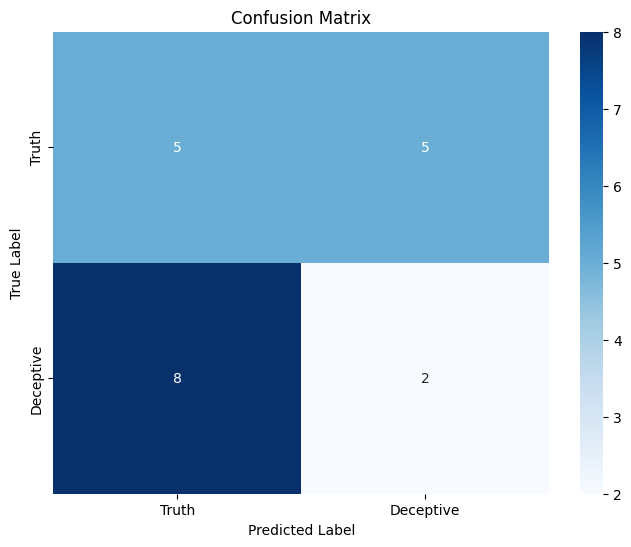

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Truth', 'Deceptive'],
            yticklabels=['Truth', 'Deceptive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()